In [1]:
# install all the necessary dependencies

import sys
!{sys.executable} -m pip install --upgrade --force-reinstall --ignore-installed --no-cache-dir pandas matplotlib faker scipy pyod numba
!{sys.executable} -m pip install numpy==1.24

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/ff/5a/c7359edec58500b35da8dc40a69ea7b0a3be48a479e1c91e8e8d0a2d9aa7/pandas-2.1.1-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/98/a7/3883b2bd4e5cff02bdb578eadf09910581220660257183145b6d2253e018/matplotlib-3.8.0-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for faker from https://files.pythonhosted.org/packages/30/50/cd430ebe6ec486ac5e13c27ae9410a0d0c510b4968a6a7a84878703d48f4/Faker-19.6.2-py3-none-any.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/62/35/4297fb91ee65883caa6c228eb8ae27db0a41353819902694c61d3bd22de1/scipy-1.11.3-cp310-cp310-macosx_12_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 8.7 M

In [2]:
# setup the base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data from cvs file
maas_df = pd.read_csv(r'./maaslar.csv')

In [3]:
# modify the data values
# create 2 random positions

#specify the random number seed
np.random.seed(7)

loc_0 = np.random.randint(0,100)
loc_1 = np.random.randint(0,100)

maas_0 = np.random.randint(0,100)
maas_1 = np.random.randint(0,100)

maas_df.at[loc_0,'Maas'] = maas_0
maas_df.at[loc_1,'Maas'] = maas_1

In [4]:
# create numpy array
maas_raw = maas_df['Maas'].values

# create a shape compatible with scipy
maas_raw = maas_raw.reshape(-1,1)
maas_raw = maas_raw.astype('float64')

# import scipy
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq

# utilize kmeans clustering
centroids, avg_distance = kmeans(maas_raw, 4)

# convert into groups
groups, cdist = vq(maas_raw, centroids)

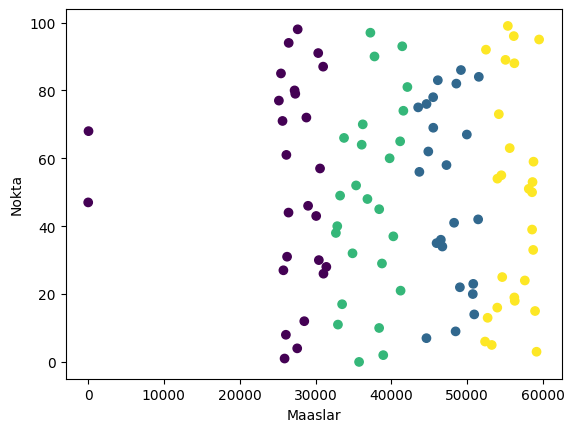

In [5]:
# create a scatter plot
plt.scatter(maas_raw,np.arange(0,100), c=groups)
plt.ylabel('Nokta')
plt.xlabel('Maaslar')
plt.show()

In [6]:
# create marker for known 
maas_df['class'] = 0
# flag the dummy records
maas_df.at[loc_0,'class'] = 1
maas_df.at[loc_1,'class'] = 1

# utilize the k-means nearest neighbor algorithm from the pyod library
from pyod.models.knn import KNN

# fit scipy
X = maas_df['Maas'].values.reshape(-1,1)
y = maas_df['class'].values

# setting contamination rate for 2 records (2%)
cluster_model = KNN(contamination=0.02,n_neighbors=5)
cluster_model.fit(X)

KNN(algorithm='auto', contamination=0.02, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [7]:
# assigning labels for the training dataset
y_train_pred = cluster_model.labels_

# scores for identifying anomalies
y_train_scores = cluster_model.decision_scores_

from pyod.utils import evaluate_print

# check the accuracy of the fit - should be 1.0 and 1.0 (very accurate)
evaluate_print('KNN',y,y_train_scores)

KNN ROC:1.0, precision @ rank n:1.0


In [8]:
# model is now trained

# perform testing for inferences

anomalous_value = np.array([[37.]])

cluster_model.predict(anomalous_value)

array([1])

In [9]:
normal_value = np.array([[32001.]])

cluster_model.predict(normal_value)

array([0])